# Developing a Multivariate Gaussian Distribution - SPT Sample

Allen Pinjic - Created on June 3rd, 2022

## Numpyro Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as plt
import arviz as az
import pandas as pd
import arviz as az
import pylab as plt
import pymc3 as pm
import seaborn as sns
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
assert numpyro.__version__.startswith("0.9.2")
import scipy.stats as stats
import scipy.optimize
import seaborn as sns
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [7]:
def model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

In [8]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train['patient_code'] = patient_encoder.fit_transform(train['Patient'].values)

FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
patient_code = train["patient_code"].values

In [9]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:39<00:00, 102.45it/s, 63 steps of size 1.00e-02. acc. prob=0.84]  


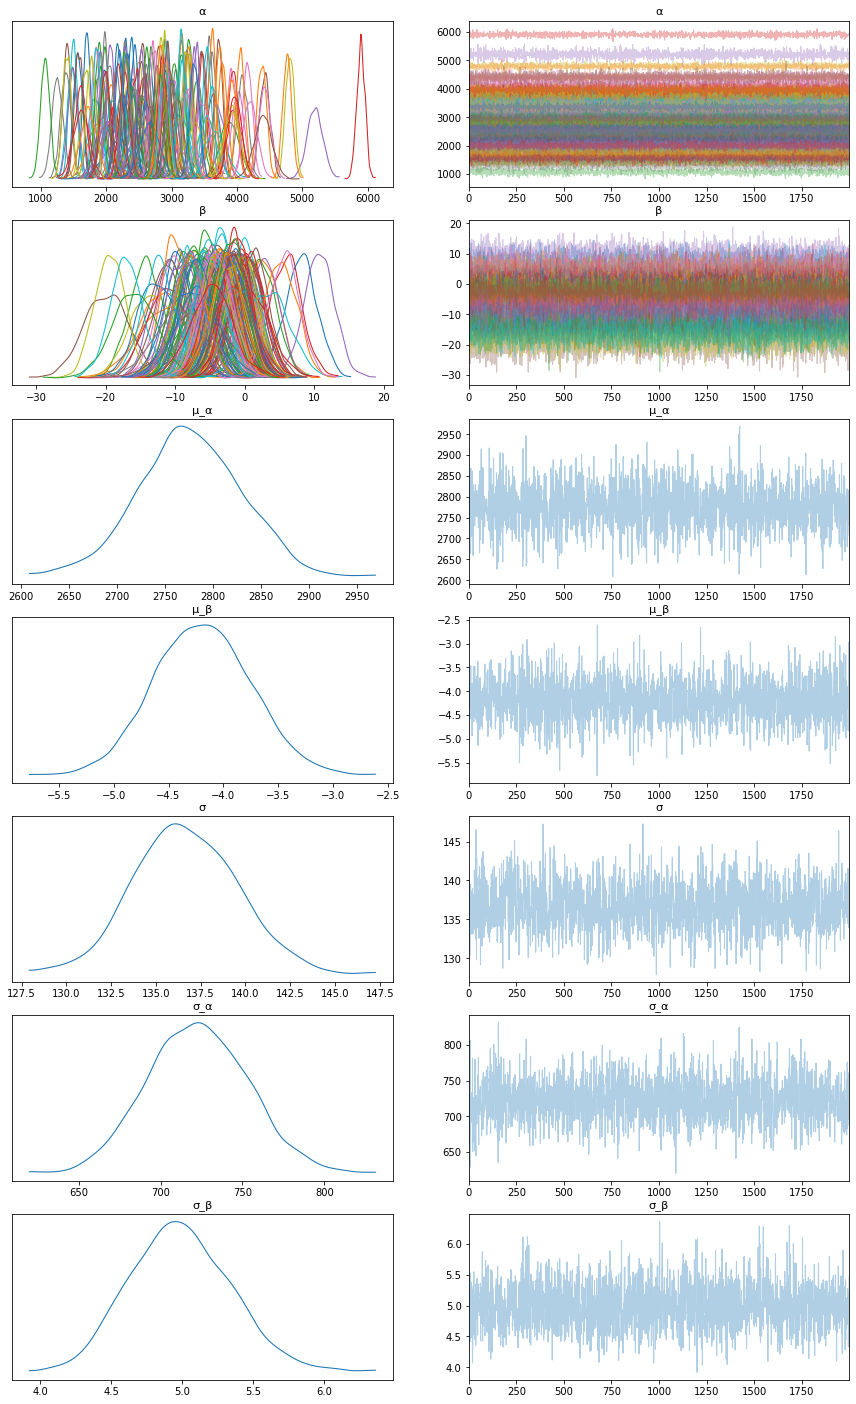

In [10]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

## Using SPT Sample

In [19]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [ ]:
def model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))
    
    # Since we have four free parameters, how can this be implemented in
    # an example that assumes two?
    
    # Do we need to also measure a data point's uniqueness
    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

## Additional Method

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import seaborn as sns

In [23]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import numpy as np

In [26]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))

df = data.to_pandas()

h = 0.7
df['log_M500'] = np.log(df.M500*1e14*h)
df['log_LAMBDA_CHISQ'] = np.log(df.LAMBDA_CHISQ)

/data0/sw/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# Calculating the log of the mean mass error
h=0.7
m500 = df.M500.to_numpy()*1e14*h
log_m500 = np.log(m500)

lerr = df.M500_LERR.to_numpy()*1e14*h
uerr = df.M500_UERR.to_numpy()*1e14*h

m500_err = (lerr+uerr)/2 # mean mass error
log_m500_err = m500_err/m500

# Eliminating NaN values from the log_m500_err data set
nnan = ~np.isnan(log_m500_err)
nnan2 = ~np.isnan(log_m500)

<ipython-input-27-ce5e59d41f0a>:4: RuntimeWarning: divide by zero encountered in log
  log_m500 = np.log(m500)
<ipython-input-27-ce5e59d41f0a>:10: RuntimeWarning: invalid value encountered in true_divide
  log_m500_err = m500_err/m500


In [28]:
# Calculating the log of the richness error

lbd = df.LAMBDA_CHISQ.to_numpy()
lbd_err = df.LAMBDA_CHISQ_E.to_numpy()

log_lbd = df.log_LAMBDA_CHISQ
log_lbd_err = lbd_err/lbd

# Eliminating NaN values from the log_lbd_err data set
nnan3 = ~np.isnan(log_lbd_err)
nnan4 = ~np.isnan(log_lbd)

nnan_all = nnan & nnan2 & nnan3 & nnan4

<ipython-input-28-41f86079a195>:7: RuntimeWarning: invalid value encountered in true_divide
  log_lbd_err = lbd_err/lbd


In [29]:
df0 = df
z = df0.REDSHIFT.to_numpy()
lbd = df0.LAMBDA_CHISQ.to_numpy()
zcut = (z > 0.1) & (z < 0.65)
lcut = lbd > 20
final_cut = zcut & lcut
# What are the constraints for z and m500 for the new paper?

In [30]:
df = df0.loc[final_cut].copy()

In [25]:
# The function of the first two lines is to make sure that regardless
# of where this code is used, the readout will always be the same
seed = 1
rng = np.random.default_rng(seed)
sns.set_style('whitegrid')

X = log_m500[nnan_all]
X = sm.add_constant(X)
Y = log_lbd[nnan_all]

In [ ]:
with pm.Model() as hierarchical_model_centered:
    # Hyperpriors for group nodes
    A_SZE = pm.Normal('A_SZE', mu=5.24, sd=0.85)
    sigma_A_SZE = pm.HalfCauchy('sigma_A_SZE', 5)
    B_SZE = pm.Normal('B_SZE', mu=1.534, sd=0.100)
    sigma_B_SZE = pm.HalfCauchy('sigma_B_SZE', 5)
    C_SZE = pm.Normal('C_SZE', mu=0.465, sd=0.407)
    sigma_C_SZE = pm.HalfCauchy('sigma_C_SZE', 5)
    scatter = pm.HalfCauchy("Scatter", 0.161)
    # normalized field depth (assumed to be a value of 1 in figure 3)
    gamma = 1

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=A_SZE, sd=sigma_A_SZE)
    
    # , shape=n_counties <---- NECESSARY?

    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=B_SZE, sd=sigma_B_SZE)
    
    
    # Since we have four free parameters, how can this be implemented in
    # an example that assumes two?

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    
    # IS M IN THE PAPER ASSUMED TO BE M500?
    
    # In this new paper, M0 and z0 are still the same
    # However, the limits of the data values for M500 and Z
    # (via the m500[nnan_all] and z[nnan_all] below)
    # for this paper's caluculations are not yet known
    
    equation1 = (np.log(A_SZE) + (B_SZE)*(np.log((m500[nnan_all])/(3e14))) + (C_SZE)*(np.log((E(z[nnan_all]))/(E(0.6)))))
    equation2 = (np.log((A_SZE)(gamma)) + (B_SZE)*(np.log((m500[nnan_all])/(3e14))) + (C_SZE)*(np.log((E(z[nnan_all]))/(E(0.6)))))
    likelihood = pm.Normal("y",mu=equation__, sigma=scatter, observed=Y)
    
    

In [ ]:
with hierarchical_model_centered:
    hierarchical_centered_trace = pm.sample(draws=5000, tune=1000, njobs=4)[1000:]

In [ ]:
pm.traceplot(hierarchical_centered_trace);